# Walmart store sales forecasting | Random Forest | XGBoost | Hyper parameter tuning


![](https://wwd.com/wp-content/uploads/2022/08/Walmart-Sign.jpg?w=1000&h=563&crop=1&resize=1000%2C563
)

# Dataset Description
    
* You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, We are forecasting the department-wide sales for each store.

* In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

## train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

* Store - the store number
* Dept - the department number
* Date - the week
* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week

## features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

* Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
* Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
* Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
* Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

# Importing Essesntial Libraries

In [1]:
# Essentials and data wrangling libraries
import numpy as np
import pandas as pd
import datetime
import random

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
!pip install jovian opendatasets --upgrade --quiet
import opendatasets as od
import jovian
import os
from zipfile import ZipFile


%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

     |████████████████████████████████| 68 kB 3.3 MB/s 


In [2]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: raghurayirath
Your Kaggle Key: ··········


100%|██████████| 2.70M/2.70M [00:00<00:00, 101MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting


In [3]:
with ZipFile('./walmart-recruiting-store-sales-forecasting/train.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting')
    
with ZipFile('./walmart-recruiting-store-sales-forecasting/test.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting') 
    
with ZipFile('./walmart-recruiting-store-sales-forecasting/features.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting') 
    
with ZipFile('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip') as f:
    f.extractall(path='walmart-recruiting-store-sales-forecasting') 

In [4]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['train.csv.zip',
 'train.csv',
 'stores.csv',
 'sampleSubmission.csv',
 'test.csv.zip',
 'features.csv.zip',
 'test.csv',
 'features.csv',
 'sampleSubmission.csv.zip']

In [5]:
train_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/train.csv')
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [6]:
test_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/test.csv')
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [7]:
features_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/features.csv')
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [8]:
stores_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/stores.csv')
stores_df

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


## Data merging


In [9]:
train_merged_df = train_df.merge(stores_df, how='left').merge(features_df, how='left')

In [10]:
train_merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


In [11]:
test_merged_df = test_df.merge(stores_df, how='left').merge(features_df, how='left')
test_merged_df

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


## Splitting Date

In [12]:
def split_date(train_merged_df):
    train_merged_df['Date'] = pd.to_datetime(train_merged_df['Date'])
    train_merged_df['Year'] = train_merged_df['Date'].dt.year
    train_merged_df['Month'] = train_merged_df['Date'].dt.month
    train_merged_df['Day'] = train_merged_df['Date'].dt.day
    train_merged_df['WeekOfYear'] = train_merged_df.Date.dt.week

In [13]:
split_date(train_merged_df)

<ipython-input-12-891f1fc5ea8a>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_merged_df['WeekOfYear'] = train_merged_df.Date.dt.week


In [14]:
split_date(test_merged_df)

<ipython-input-12-891f1fc5ea8a>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_merged_df['WeekOfYear'] = train_merged_df.Date.dt.week


In [15]:
train_merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,28,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,2012,10,5,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,2012,10,12,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,2012,10,19,42


In [16]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

## Checking Missing values


In [17]:
missing_values = train_merged_df.isna().sum().sort_values(ascending=False)[:5]
missing_values

MarkDown2    310322
MarkDown4    286603
MarkDown3    284479
MarkDown1    270889
MarkDown5    270138
dtype: int64

In [18]:
fig = px.bar(missing_values, x=missing_values.index, y=missing_values.values, color=missing_values.index,
      text=missing_values.values, title='missing value count')
fig.update_traces(width=0.4)
fig.update_layout(
    xaxis_title="Features",
    yaxis_title="Missing value count",
    font = dict(size=17))
fig.show()

## Observations
*  Markdown 1-5 contains lots of missing values, more than 250000 missing values counts in each markdown columns
*  Markdown columns correspond to the promotional activities being carried out at different wallmart stores.
* The promotional markdowns only started after November 2011, Promotional offers/markdowns are listed in specific stores. That is the reason markdown feature column contains lots of missing values compared to the other columns/features.
* Lets perform the exploratory data analysis and find the correlation between and weekly sales and markdown columns, based on that result we can perform the missing value treatment.

## Exploratory Data Analysis

In [19]:
train_merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,28,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,2012,10,5,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,2012,10,12,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,2012,10,19,42


## Store type

In [20]:
type_df = train_merged_df['Type'].value_counts()

In [21]:
fig = px.pie(type_df, values=type_df.values, names=type_df.index,title='store type', hole=.3)
fig.update_traces(textinfo='label+percent', textfont_size=18,
                  marker=dict(line=dict(color='#e3eaa7', width=0.2)))

fig.update_layout(
    font = dict(size=17))
fig.show()

## Observations
* store type A contains 51.1% of the dataset
* store type B contains 38.8%
* store type C conatins 10.1%
* Type A stores are more popular than the B and C types

## Avg sales

In [22]:
avg_sales_df = train_merged_df.groupby('Type')['Weekly_Sales'].mean().round(2)
avg_sales_df

Type
A    20099.57
B    12237.08
C     9519.53
Name: Weekly_Sales, dtype: float64

In [23]:
fig = px.bar(avg_sales_df, x=avg_sales_df.index, y=avg_sales_df.values, color=avg_sales_df.index,
      text=avg_sales_df.values, title='avg sales')
fig.update_traces(width=0.2)
fig.update_layout(
    xaxis_title="Store type",
    yaxis_title="Average sales",
    font = dict(size=17))
fig.show()

## Observations

* Store type A recorded highest avg sales of $ 20.7K. <br>

* Store type C recorded least avg sales OF $9.5k

## Avg Monthly sales


In [24]:
avg_monthly_sales = train_merged_df.groupby('Month')['Weekly_Sales'].mean().round(2)
avg_monthly_sales

Month
1     14126.08
2     16008.78
3     15416.66
4     15650.34
5     15776.34
6     16326.14
7     15861.42
8     16062.52
9     15095.89
10    15243.86
11    17491.03
12    19355.70
Name: Weekly_Sales, dtype: float64

In [25]:
fig = px.bar(avg_monthly_sales, x=avg_monthly_sales.index, y=avg_monthly_sales.values, color=avg_monthly_sales.index,
      text=avg_monthly_sales.values, title='avg sales')
fig.update_traces(width=0.4)
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Average monthly sales",
    font = dict(size=17))
fig.update_xaxes(tick0=1, dtick=1)
fig.show()

## Observations

* January month recorded the lowest avarage weekly sales of 14.12k compared with other months <br>
* December month recorded the most average weekly sales compared with other months 19.35K 


In [26]:
yearly_avg_sales_df = train_merged_df.groupby('Year')['Weekly_Sales'].mean().round(2)
yearly_avg_sales_df

Year
2010    16270.28
2011    15954.07
2012    15694.95
Name: Weekly_Sales, dtype: float64

In [27]:
fig = px.pie(yearly_avg_sales_df, values=yearly_avg_sales_df.values, names=yearly_avg_sales_df.index,
             title='Yearly avg sales', hole=.3)
fig.update_traces(textinfo='label+percent', textfont_size=18,
                  marker=dict(line=dict(color='#e3eaa7', width=0.2)))

fig.update_layout(
    font = dict(size=17))
fig.show()

## Observations

* 2010 recorded maximum sales of 34%
* 2010, 2011, 2012 are recorded around same percentage of avg sales

## Average store sales


In [28]:
avg_store_sales = train_merged_df.groupby('Store')['Weekly_Sales'].mean().round(2)

In [29]:
train_merged_df


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,28,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,2012,10,5,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,2012,10,12,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,2012,10,19,42


In [30]:
fig = px.bar(avg_store_sales, x=avg_store_sales.index, y=avg_store_sales.values, color=avg_store_sales.index,
      text=avg_store_sales.values, title='avg store sales' ,
      labels={'x':'Stores', 'y':'Sales'})
fig.update_traces(width=0.9)
fig.update_layout(
    xaxis_title="Store",
    yaxis_title="Average store sales",
    font = dict(size=17))
fig.update_xaxes(tick0=1, dtick=1)
fig.show()

Insights:

* The sales vary by large amount among the 45 stores
* It really depends which category of store it is and which week of the particular year is under consideration

## Store sales year wise

In [31]:
filt_2010 = train_merged_df['Year'] == 2010
sales_2010_df = train_merged_df[filt_2010]
avg_sales_2010_storewise = sales_2010_df.groupby('Store')['Weekly_Sales'].mean().round(2)
avg_sales_2010_storewise[:5]


filt_2011 = train_merged_df['Year'] == 2011
sales_2011_df = train_merged_df[filt_2011]
avg_sales_2011_storewise = sales_2011_df.groupby('Store')['Weekly_Sales'].mean().round(2)
avg_sales_2011_storewise[:5]


filt_2012 = train_merged_df['Year'] == 2012
sales_2012_df = train_merged_df[filt_2012]
avg_sales_2012_storewise = sales_2012_df.groupby('Store')['Weekly_Sales'].mean().round(2)
avg_sales_2012_storewise[:5]

Store
1    22179.53
2    26451.38
3     6621.76
4    29974.54
5     5253.56
Name: Weekly_Sales, dtype: float64

In [32]:
fig1 = px.bar(avg_sales_2010_storewise, x=avg_sales_2010_storewise.index, y=avg_sales_2010_storewise.values, 
      color=avg_sales_2010_storewise.index,
      text=avg_store_sales.values, title='avg store sales 2010' ,
      labels={'x':'Stores', 'y':'Sales'})
fig1.update_traces(width=0.9)
fig1.update_layout(
    xaxis_title="Store",
    yaxis_title="Average store sales 2010",
    font = dict(size=17))
fig1.update_xaxes(tick0=1, dtick=1)
fig1.show()

fig2 = px.bar(avg_sales_2011_storewise, x=avg_sales_2011_storewise.index, y=avg_sales_2011_storewise.values, 
      color=avg_sales_2011_storewise.index,
      text=avg_sales_2011_storewise.values, title='avg store sales 2011' ,
      labels={'x':'Stores', 'y':'Sales'})
fig2.update_traces(width=0.9)
fig2.update_layout(
    xaxis_title="Store",
    yaxis_title="Average store sales 2011",
    font = dict(size=17))
fig2.update_xaxes(tick0=1, dtick=1)
fig2.show()


fig3 = px.bar(avg_sales_2012_storewise, x=avg_sales_2012_storewise.index, y=avg_sales_2012_storewise.values, 
       color=avg_sales_2012_storewise.index,
      text=avg_sales_2012_storewise.values, title='avg store sales 2012' ,
      labels={'x':'Stores', 'y':'Sales'})
fig3.update_traces(width=0.9)
fig3.update_layout(
    xaxis_title="Store",
    yaxis_title="Average store sales 2012",
    font = dict(size=17))
fig3.update_xaxes(tick0=1, dtick=1)
fig3.show()

## Observations
* Store ID 20 and 14 recorded comparatively highest avg yearly sales for 2010, 2011 and 2012.
* Store ID 33 and 5 recorded lowest average yearly sales compared with other stores

## Average Weekly Sales - per Year

In [33]:
weekly_sales_2010 = sales_2010_df.groupby('WeekOfYear')['Weekly_Sales'].mean()
weekly_sales_2011 = sales_2011_df.groupby('WeekOfYear')['Weekly_Sales'].mean()
weekly_sales_2012 = sales_2012_df.groupby('WeekOfYear')['Weekly_Sales'].mean()

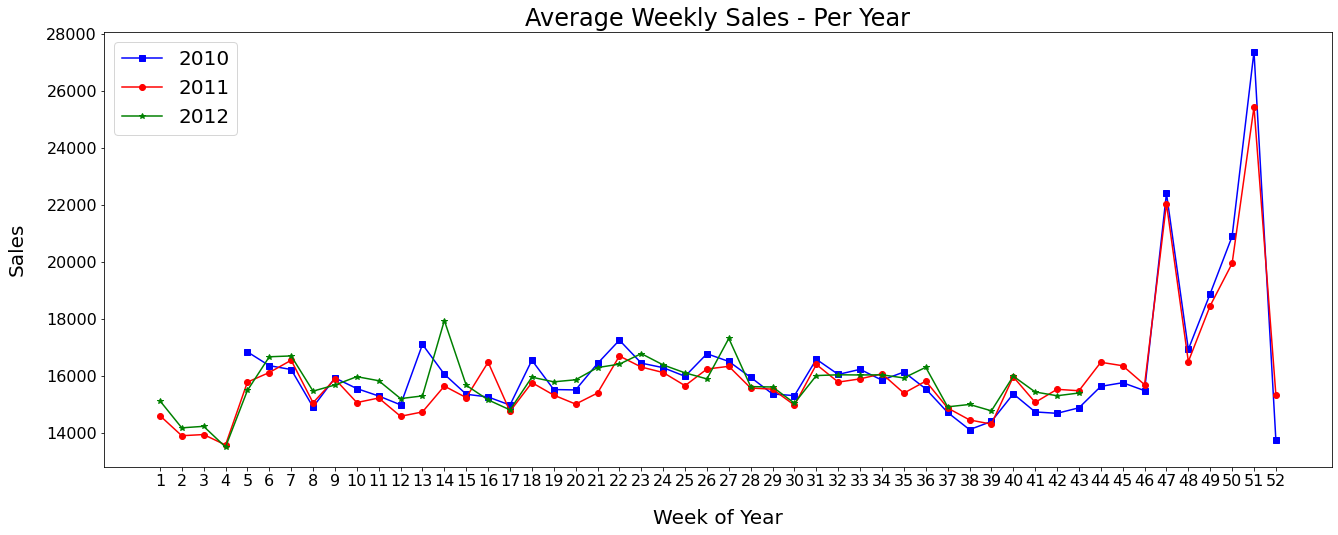

In [34]:
plt.figure(figsize=(22,8))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values, 's-b')
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values, 'o-r')
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values, '*-g')

plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20)

plt.title("Average Weekly Sales - Per Year", fontsize=24)
plt.legend(['2010', '2011', '2012'], fontsize=20);

## Observations

* week 46 onwards we can observe drastically increasing the sales trend.
* After new year, week 1-4 , weekly sales trend are drastically decresing. 
* week 4 onwards weekly sales showing normal trend until year end.

## Top 10 Average Department sales

In [35]:
top_10_avg_dept_sales_df = train_merged_df.groupby('Dept')['Weekly_Sales'].mean().round(2).sort_values(ascending=False)[:10]
top_10_avg_dept_sales_df

Dept
92    75204.87
95    69824.42
38    61090.62
72    50566.52
65    45441.71
90    45232.08
40    44900.70
2     43607.02
91    33687.91
94    33405.88
Name: Weekly_Sales, dtype: float64

In [36]:
fig3 = px.bar(top_10_avg_dept_sales_df, x=top_10_avg_dept_sales_df.index, y=top_10_avg_dept_sales_df.values, 
       color=top_10_avg_dept_sales_df.index,
      text=top_10_avg_dept_sales_df.values, title='Avg Dept sales' ,
      labels={'x':'Dept', 'y':'Avg Sales'})
fig3.update_traces(width=5)
fig3.update_layout(
    xaxis_title="Dept",
    yaxis_title="Avg Dept sales",
    font = dict(size=17))
fig3.show()

## Observations

* Dept 95 and 92 are showing the highest weekly sales of 75K and 69K, compared with other wallmart departments

## Holiday v/s Non holiday sales

In [37]:
holiday_df = train_merged_df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_df

IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64

In [38]:
holiday_count_df = train_merged_df['IsHoliday'].value_counts()
holiday_count_df

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [39]:
fig = px.pie(holiday_df, values=holiday_df.values, names=holiday_df.index,
             title='Holiday vs non-holiday sales', hole=.3)
fig.update_traces(textinfo='label+percent', textfont_size=18,
                  marker=dict(line=dict(color='#e3eaa7', width=0.2)))

fig.update_layout(
    font = dict(size=17))
fig.show()

## Observations

* Only 13% of the days are fall into holiday,Only that 13% of holidays recorded the 51% of the sales. 
* From 87% of the non-holidays recorded only 49% of the total sales.


##  Week of year vs sales

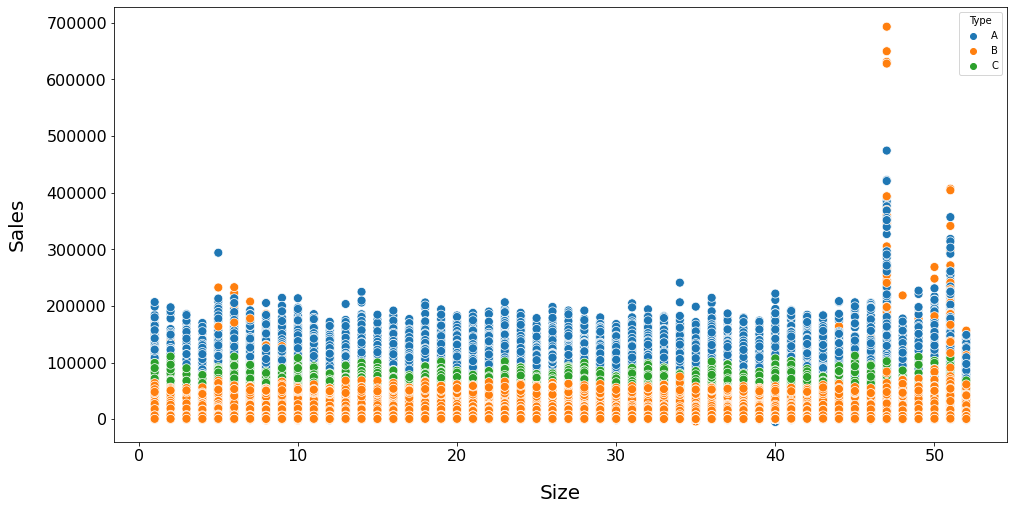

In [40]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged_df.WeekOfYear, y=train_merged_df.Weekly_Sales, hue=train_merged_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

## Observation

* We can observe that weekly sales gradually increases the end of the year espicially on store type A and B

In [41]:
train_merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,28,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,2012,10,5,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,2012,10,12,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,2012,10,19,42


## Size of store v/s sales

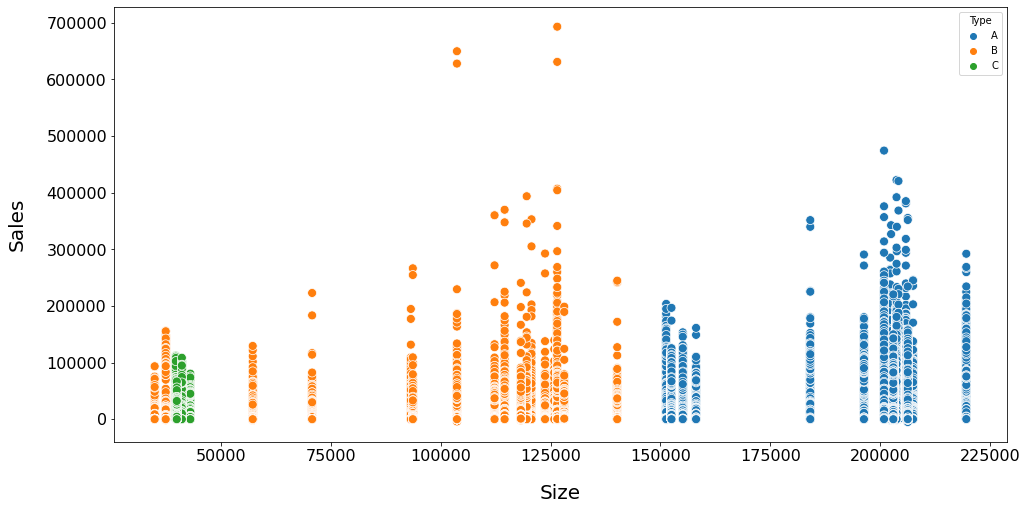

In [42]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged_df.Size, y=train_merged_df.Weekly_Sales, hue=train_merged_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

## Observation
* Size of the store and weekly sales shows the slighly linear relationship, store slares gradually increases if the store size increases

## Relationship: Unemployment vs Sales

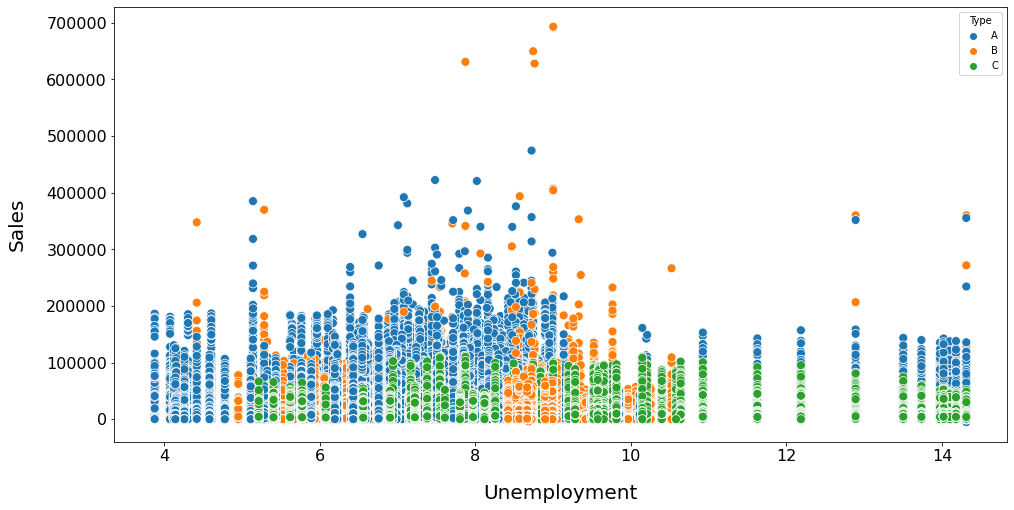

In [43]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged_df.Unemployment, y=train_merged_df.Weekly_Sales, hue=train_merged_df.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

# Observation
* We cant find any linear relationship between unemployment and weekly sales
* But we can observe that a week correlation between unemploymemnt  and weekly sales
* weekly sales very slighly decreases if unemployment rate increases

## Correlation Matrix

* Lets study the relationship between the different columns numerically to check how they correlate with the weekly sales in order to confirm the inferences we have gathered from the above EDA study. 
* Since the correlation value can only be calculated for the numerical columns, so we will first convert the 'Type' column to numerical values. Type 'A', 'B' and 'C' will be mapped to 1, 2 and 3 respectively

In [113]:
storetype_values = {'A':3, 'B':2, 'C':1}
train_merged_df['Type_Numeric'] = train_merged_df.Type.map(storetype_values)
test_merged_df['Type_Numeric'] = test_merged_df.Type.map(storetype_values)

AttributeError: ignored

In [ ]:
corr_matrix= train_merged_df.corr()
corr_matrix

In [ ]:
plt.subplots(figsize=(30,20))
ax = sns.heatmap(corr_matrix, annot=True,cmap="RdYlGn")
ax

## Extracting most correlated features

In [47]:
print("Highly correlated features")
corr_matrix['Weekly_Sales'].sort_values(ascending=False)[:10]

Highly correlated features


Weekly_Sales    1.000000
Size            0.243828
Type_Numeric    0.182242
Dept            0.148032
MarkDown5       0.090362
MarkDown1       0.085251
MarkDown3       0.060385
MarkDown4       0.045414
Month           0.028409
WeekOfYear      0.027673
Name: Weekly_Sales, dtype: float64

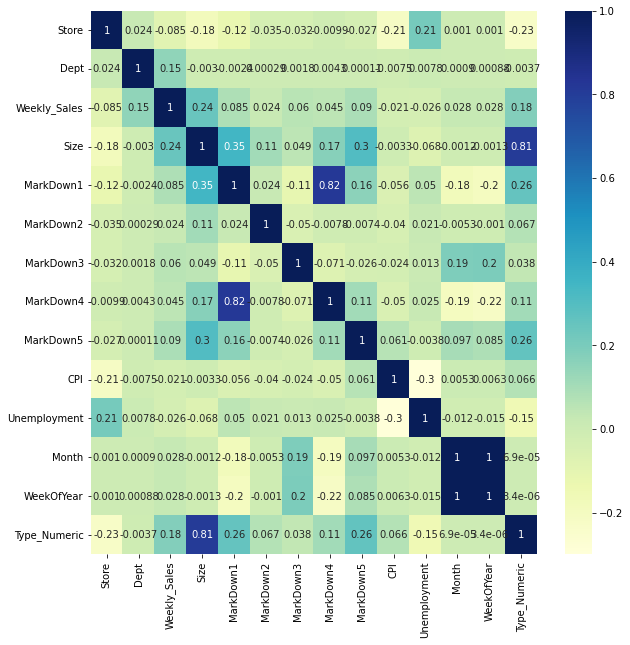

In [48]:
top_corr_features = corr_matrix.index[abs(corr_matrix["Weekly_Sales"])>0.02]
plt.figure(figsize=(10,10))
g = sns.heatmap(train_merged_df[top_corr_features].corr(),annot=True,cmap="YlGnBu")

Insights:
* Department, Store size have have moderate correlation with the weekly sales
* Markdown1-5 have very weak correlation with the weekly sales
* Temperature. Fuel price, CPI and Unemployment are very weakly coorelated with the weekly sales, so these columns will also be dropped out
* IsHoliday will be considered for the further analysis as the sales in the holiday weeks are higher than in the non-holiday weeks
* We will also leave out Month and Day as this information is already contained in the WeekOfYear

## Data Preparation for Model Training


Following steps will be performed for preparing the data for the subsequent model training

* Based on the Exploratory Data Analysis and Coorelation study, the columns with weak relationship with the target column will be dropped
* Input and Target dataframes will be created
* Inputs will be scaled in the 0 to 1 range
* Training and Validation datasets will be created
* A function will be defined based on which the models performance will be measured

In [49]:
train_merged_df = train_merged_df.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Day' ], axis=1)

test_merged_df = test_merged_df.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Day' ], axis=1)

In [50]:
input_cols = train_merged_df.columns.to_list()
input_cols.remove('Weekly_Sales')
target_col = 'Weekly_Sales'

In [51]:
inputs_df = train_merged_df[input_cols].copy()
targets = train_merged_df[target_col].copy()

## Scale the values

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_merged_df[input_cols])

inputs_df[input_cols] = scaler.transform(inputs_df[input_cols])
test_merged_df[input_cols] = scaler.transform(test_merged_df[input_cols])

## Create training and validation sets

In [53]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df, targets, test_size=0.3, random_state=42)

In [54]:
inputs_df

,Store,Dept,IsHoliday,Size,Year,WeekOfYear,Type_Numeric
0,0.0,0.000000,0.0,0.630267,0.0,0.078431,1.0
1,0.0,0.000000,1.0,0.630267,0.0,0.098039,1.0
2,0.0,0.000000,0.0,0.630267,0.0,0.117647,1.0
3,0.0,0.000000,0.0,0.630267,0.0,0.137255,1.0
4,0.0,0.000000,0.0,0.630267,0.0,0.156863,1.0
...,...,...,...,...,...,...,...
421565,1.0,0.989796,0.0,0.451136,1.0,0.745098,0.5
421566,1.0,0.989796,0.0,0.451136,1.0,0.764706,0.5
421567,1.0,0.989796,0.0,0.451136,1.0,0.784314,0.5
421568,1.0,0.989796,0.0,0.451136,1.0,0.803922,0.5


In [55]:
val_inputs

,Store,Dept,IsHoliday,Size,Year,WeekOfYear,Type_Numeric
272342,0.613636,0.397959,0.0,0.927901,1.0,0.000000,1.0
176581,0.386364,0.938776,0.0,0.464300,1.0,0.176471,0.5
354212,0.840909,0.030612,0.0,0.026063,0.5,0.392157,0.0
281444,0.636364,0.326531,0.0,0.318073,0.0,0.176471,0.5
124208,0.272727,0.520408,0.0,1.000000,0.0,0.823529,1.0
...,...,...,...,...,...,...,...
83033,0.181818,0.316327,0.0,0.492338,1.0,0.372549,0.5
283275,0.636364,0.551020,0.0,0.318073,0.0,0.372549,0.5
396800,0.931818,0.908163,0.0,0.026063,0.5,0.509804,0.0
325366,0.750000,0.357143,0.0,0.667069,0.5,0.058824,1.0


In [56]:
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
def  calculate_results(df, y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred , squared=False)
    R2_score = r2_score(y_true, y_pred)
    weights = df.IsHoliday.apply(lambda x: 5 if x else 1)
    WMAE = np.round(np.sum(weights*abs(y_true-y_pred))/(np.sum(weights)), 2)
    
    model_results = {"Root Mean Squared Error (RMSE)": RMSE,
                     "Adjusted R^2 Score": R2_score,
                    "WMAE":WMAE }
    return model_results  
    

# Linear regression

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
linear_model = LinearRegression().fit(train_inputs, train_targets)

In [60]:
train_preds = linear_model.predict(train_inputs)

In [61]:
val_preds = linear_model.predict(val_inputs)

## Train Results

In [62]:
train_results = calculate_results(train_inputs, train_targets, train_preds)
pd.DataFrame(train_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),21683.623477
Adjusted R^2 Score,0.085482
WMAE,14776.360000


## Validation Results

In [63]:
val_results = calculate_results(val_inputs ,val_targets, val_preds)
pd.DataFrame(val_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),21798.059673
Adjusted R^2 Score,0.085694
WMAE,14884.370000


# Dicision tree

In [64]:
from sklearn.tree import DecisionTreeRegressor


In [65]:
tree_model = DecisionTreeRegressor().fit(train_inputs, train_targets)

In [66]:
train_preds = tree_model.predict(train_inputs)

In [67]:
val_preds = tree_model.predict(val_inputs)

## Train Set Results


In [68]:
train_results = calculate_results(train_inputs, train_targets, train_preds)
pd.DataFrame(train_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),2.676609e-17
Adjusted R^2 Score,1.000000e+00
WMAE,0.000000e+00


## Validation set results

In [69]:
val_results = calculate_results(val_inputs ,val_targets, val_preds)
pd.DataFrame(val_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),4984.031923
Adjusted R^2 Score,0.952201
WMAE,1942.610000


## Feature Importance

In [70]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df

,feature,importance
1,Dept,0.634894
3,Size,0.209777
0,Store,0.069725
5,WeekOfYear,0.063555
6,Type_Numeric,0.013296
4,Year,0.007160
2,IsHoliday,0.001593


In [71]:
fig= px.bar(importance_df, x='feature', y='importance', color='feature', text='importance')
fig

# Random Forest


In [72]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_jobs=-1, random_state=42).fit(train_inputs, train_targets)

In [73]:
rf_train_preds = rf_model.predict(train_inputs)

In [74]:
rf_val_preds = rf_model.predict(val_inputs)

In [75]:
rf_test_preds = rf_model.predict(test_merged_df)

## Train set results


In [76]:
train_results = calculate_results(train_inputs, train_targets, rf_train_preds)
pd.DataFrame(train_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),1300.978243
Adjusted R^2 Score,0.996708
WMAE,572.070000


## Validation set results

In [77]:
val_results = calculate_results(val_inputs ,val_targets, rf_val_preds)
pd.DataFrame(val_results, index=['values']).T

,values
Root Mean Squared Error (RMSE),3751.514045
Adjusted R^2 Score,0.972919
WMAE,1592.290000


In [78]:
feature_importance_df = {'feature': train_inputs.columns,
                        'importance': rf_model.feature_importances_}

feature_importance_df = pd.DataFrame(feature_importance_df).sort_values('importance', ascending=False)
feature_importance_df

,feature,importance
1,Dept,0.631811
3,Size,0.208833
0,Store,0.071616
5,WeekOfYear,0.063428
6,Type_Numeric,0.015019
4,Year,0.007100
2,IsHoliday,0.002193


In [79]:
fig= px.bar(feature_importance_df, x='feature', y='importance', color='feature', text='importance')
fig

## Kaggle submission random_forest

In [80]:
def generate_submission(rf_test_preds, fname):
  sub_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')
  sub_df['Weekly_Sales'] = rf_test_preds
  sub_df.to_csv(fname, index=None)

In [81]:
generate_submission(rf_test_preds,'random_forest_submission.csv' )

## Tuning of Random Forest Parameters

Let's define two functions which assist the tuning of hyper parameters.

'test_params' takes the parameters of Random Forest and train the model. After that it make predictions of the training and validation and return weighted mean averaged error for the traing and validation data.

'test_param_and_plot' takes the parameter name and the range of values to be tested. For these values 'test_params' is called inside the funtion to train and evaluate the model. Finally the training and validation errors are plotted against the tested values.

In [82]:
#def test_params(**params):
   # model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
   # train_results = calculate_results(train_inputs, train_targets, rf_train_preds)
   # val_results = calculate_results(val_inputs ,val_targets, rf_val_preds)
   # return train_results, val_results

In [83]:
def WMAE(df, targets, predictions):
    weights = df.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(targets-predictions))/(np.sum(weights)), 2)

In [84]:
def test_params(**params):  
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_wmae = WMAE(train_inputs, train_targets, model.predict(train_inputs))
    val_wmae = WMAE(val_inputs, val_targets, model.predict(val_inputs))
    return train_wmae, val_wmae

In [85]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

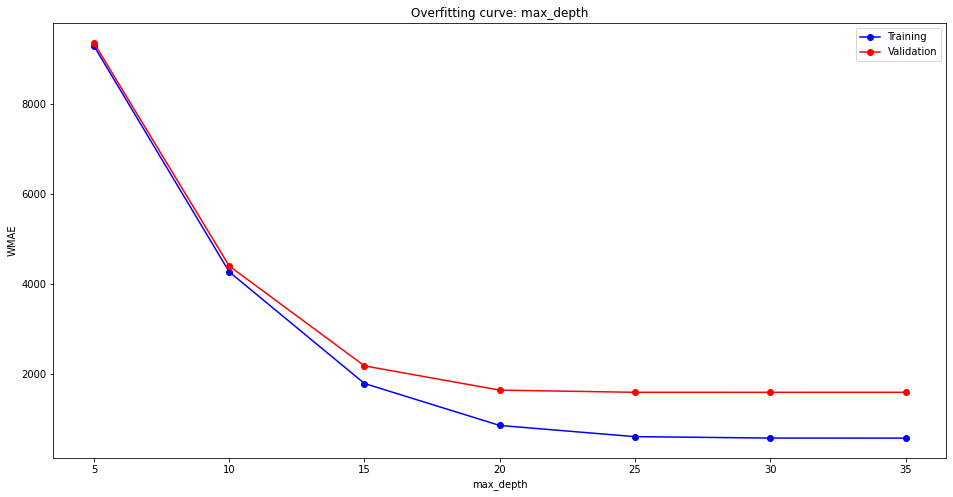

In [86]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])


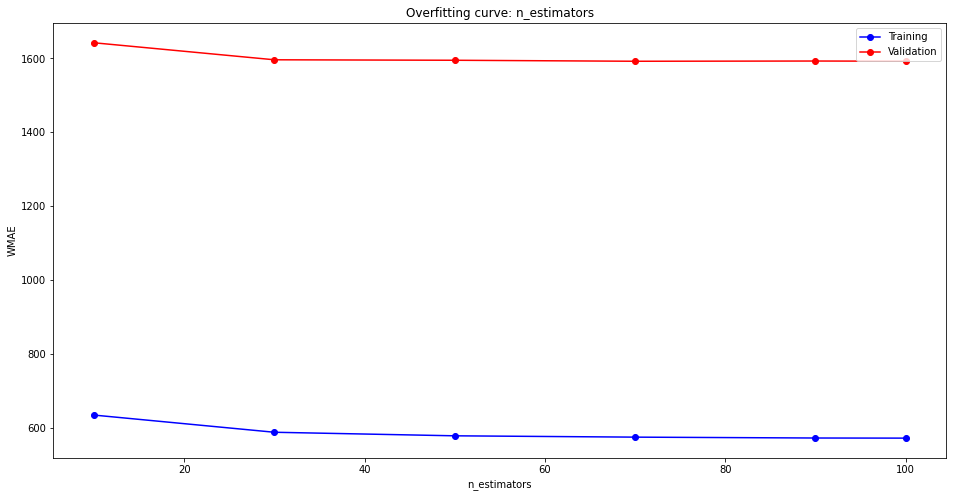

In [87]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

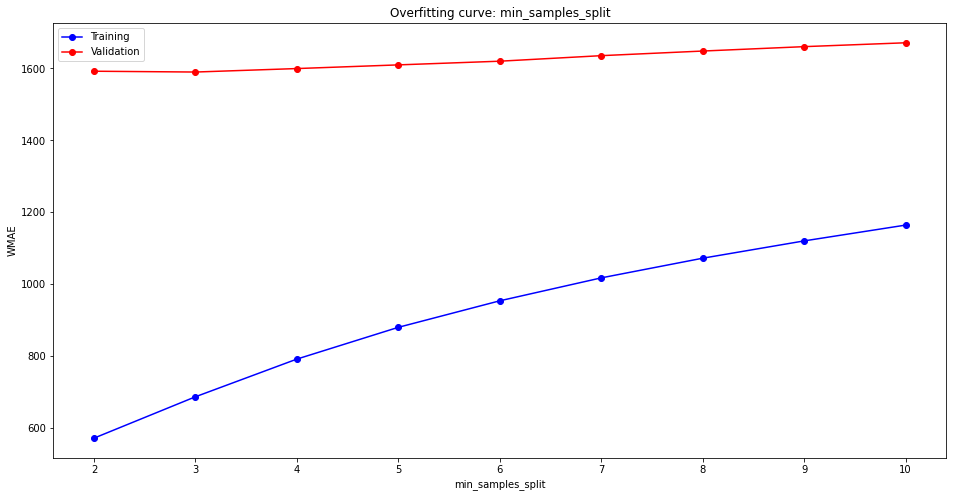

In [88]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

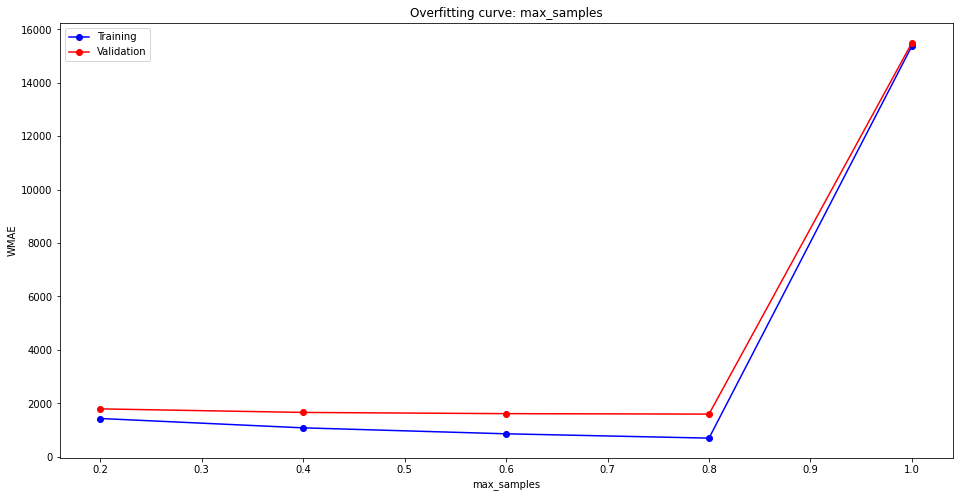

In [89]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])


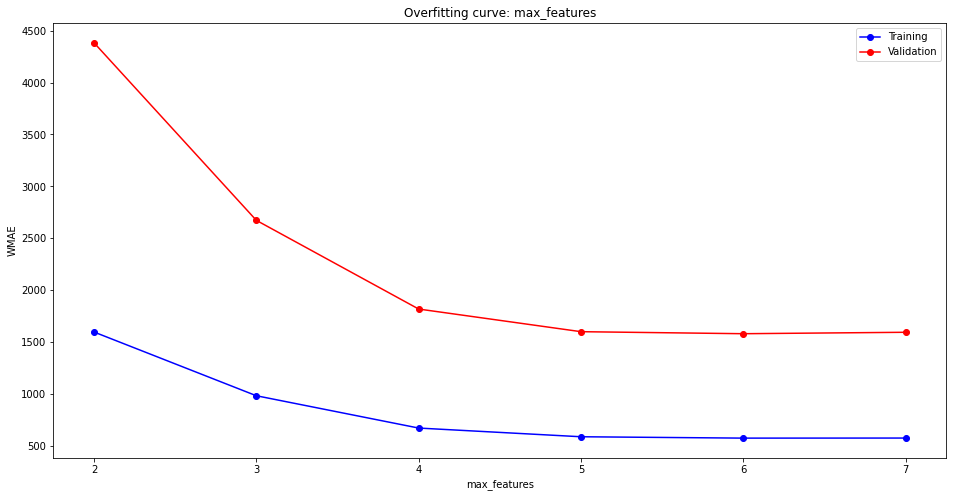

In [90]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6, 7])


In [91]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'max_depth': 25,
    'n_estimators': 50,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_samples': 0.8,
    'max_features': 5
    
}

In [92]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
rf_tuned = RandomForestRegressor(n_jobs=-1, max_depth=25, n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_samples=0.8, max_features=5, random_state=42)

# Fit the model
rf_tuned.fit(train_inputs, train_targets)

rf_tuned_train_preds = rf_tuned.predict(train_inputs)

# Compute WMAE on traing data
rf_tuned_train_wmae = WMAE(train_inputs, train_targets, rf_tuned_train_preds)
print('The WMAE loss for the training set is  {}.'.format(rf_tuned_train_wmae))

rf_tuned_val_preds = rf_tuned.predict(val_inputs)

# Compute WMAE on validation data
rf_tuned_val_wmae = WMAE(val_inputs, val_targets, rf_tuned_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(rf_tuned_val_wmae))

The WMAE loss for the training set is  751.14.
The WMAE loss for the validation set is  1633.98.


In [93]:
rf_tuned_test_preds = rf_tuned.predict(test_merged_df)
rf_tuned_test_preds

array([29200.336 , 19874.1256, 19356.809 , ...,   698.0692,   767.4224,
         698.137 ])

In [94]:
def generate_submission(rf_test_preds, fname):
  sub_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')
  sub_df['Weekly_Sales'] = rf_test_preds
  sub_df.to_csv(fname, index=None)

In [95]:
generate_submission(rf_tuned_test_preds, 'rf_tuned_submission.csv')

# Gradient Boosting Machine

In [96]:
!pip install xgboost lightgbm --upgrade --quiet


     |████████████████████████████████| 193.6 MB 86 kB/s 
     |████████████████████████████████| 2.0 MB 62.4 MB/s 


In [97]:
from xgboost import XGBRegressor

In [98]:
gbm = XGBRegressor(random_state=42, n_jobs=-1).fit(train_inputs, train_targets)

In [99]:
gbm_train_preds = gbm.predict(train_inputs)

In [100]:
gbm_val_preds = gbm.predict(val_inputs)

In [101]:
gbm_train_wmae = WMAE(train_inputs, train_targets, gbm_train_preds)
gbm_val_wmae = WMAE(val_inputs, val_targets, gbm_val_preds)

In [102]:
print(gbm_train_wmae)
print(gbm_val_wmae)

2979.66
3090.44


In [103]:
feature_importance_df = pd.DataFrame({'feature': train_inputs.columns,
'importance': gbm.feature_importances_}).sort_values('importance', ascending=False)

In [104]:
feature_importance_df

,feature,importance
1,Dept,0.407282
3,Size,0.256023
6,Type_Numeric,0.121150
0,Store,0.100716
5,WeekOfYear,0.068051
2,IsHoliday,0.037001
4,Year,0.009776


In [105]:
fig= px.bar(feature_importance_df, x='feature', y='importance', color='feature', text='importance')
fig

## GBM parameter tuning

In [114]:
def test_params_xgb(**params):  
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_wmae = WMAE(train_inputs, train_targets, model.predict(train_inputs))
    val_wmae = WMAE(val_inputs, val_targets, model.predict(val_inputs))
    return train_wmae, val_wmae

In [115]:
def test_param_and_plot_xgb(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params_xgb(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

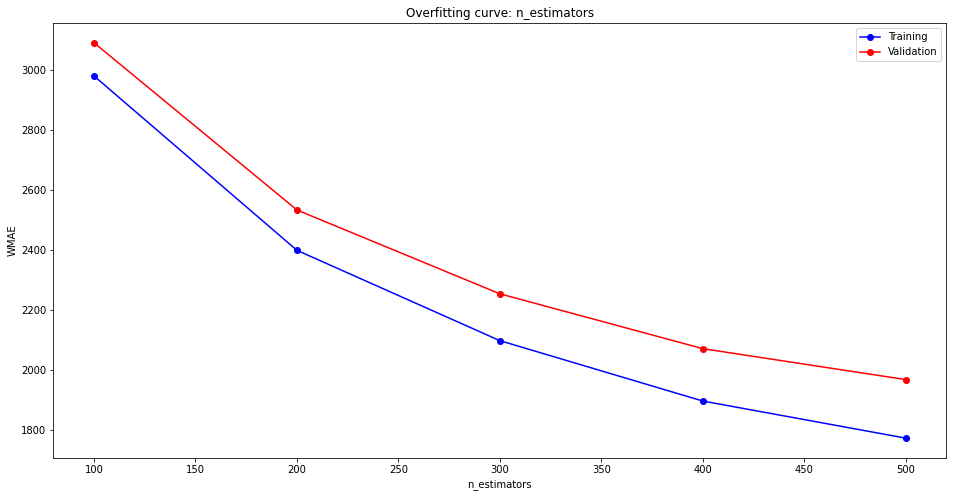

In [116]:
test_param_and_plot_xgb('n_estimators', [100, 200, 300, 400, 500])

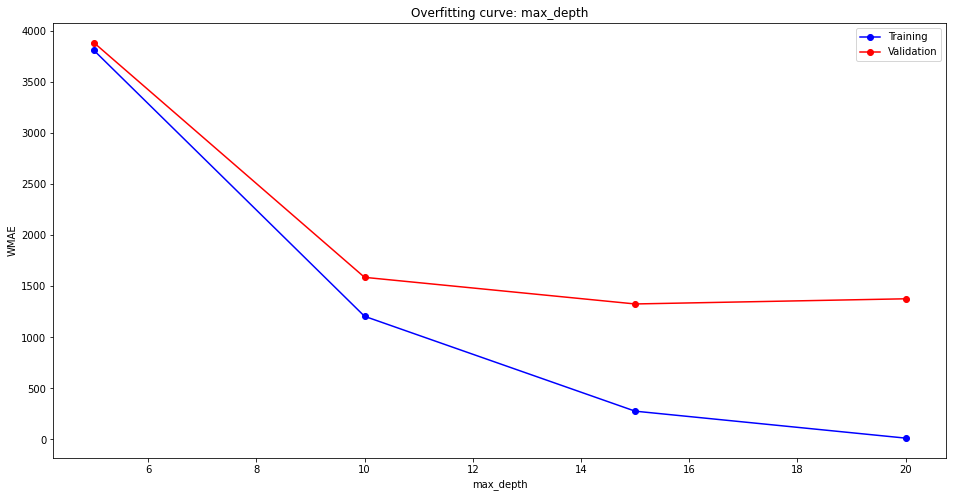

In [117]:
test_param_and_plot_xgb('max_depth', [5, 10, 15, 20])

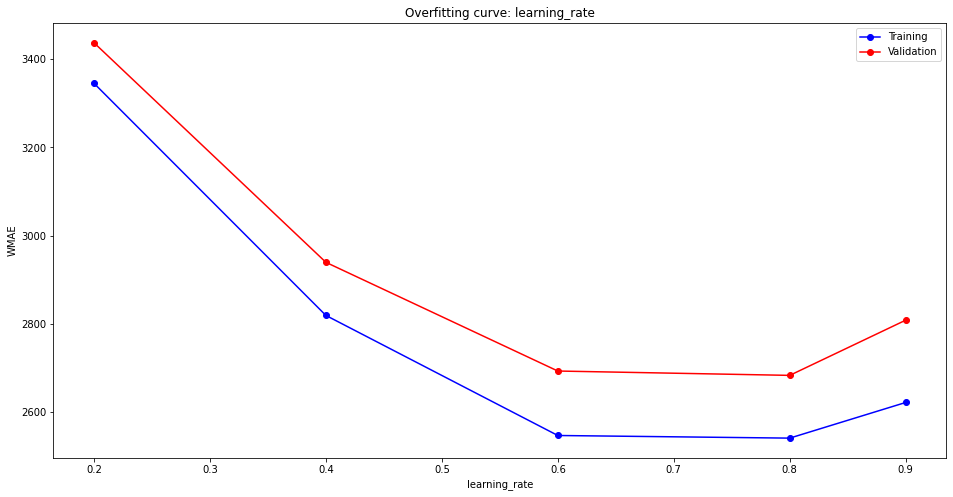

In [118]:
test_param_and_plot_xgb('learning_rate', [0.2, 0.4, 0.6, 0.8, 0.9])

In [119]:
# Create the model
gbm_tuned = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=500, max_depth=15, learning_rate=0.70).fit(train_inputs, train_targets)


In [120]:
gbm_tuned_train_preds = gbm_tuned.predict(train_inputs)

In [121]:
gbm_tuned_val_preds = gbm_tuned.predict(val_inputs)

In [122]:
gbm_tuned_train_wmae = WMAE(train_inputs, train_targets, gbm_tuned_train_preds)
gbm_tuned_val_wmae = WMAE(val_inputs, val_targets, gbm_tuned_val_preds)

In [123]:
print(gbm_tuned_train_wmae)
print(gbm_tuned_val_wmae)

0.1
1517.64


In [124]:
gbm_tuned_test_preds = gbm_tuned.predict(test_merged_df)

In [125]:
generate_submission(gbm_tuned_test_preds, 'gbm_tuned_submission.csv')

# Insights and Conclusions

Following inferences and conclusions can be drawn from the the analysis of the data:

* Weekly Sales are effected by the week of year. Holiday weeks witnessed more sales than the non-holiday weeks. Notables are Thanksgiving and Christmas weeks

* Size of the store is a major contributing factor in the weekly sales

* Type 'A' stores are more popular than 'B' and 'C' types

* Type 'A' stores outclass the 'B' and 'C' types in terms of size and the avergae weekly sales

* Sales are also dependent on the department of the store as different departments showed different levels of weekly sales

* Among the trained models for predicting the future sales, Grdient Boosting Machine with tuned hyperparameters performs the best
* Store type A recorded highest avg sales of 20.7K.

* Store type C recorded least avg sales OF 9.5k
* January month recorded the lowest avarage weekly sales of 14.12k compared with other months
* December month recorded the most average weekly sales compared with other months 19.35K
* 2010 recorded maximum sales of 34%
* 2010, 2011, 2012 are recorded around same percentage of avg sales
* The sales vary by large amount among the 45 stores
* It really depends which category of store it is and which week of the particular year is under consideration
* Store ID 20 and 14 recorded comparatively highest avg yearly sales for 2010, 2011 and 2012.
* Store ID 33 and 5 recorded lowest average yearly sales compared with other stores.
* EWeek 46 onwards we can observe drastically increasing the sales trend.
* After new year, week 1-4 , weekly sales trend are drastically decresing.
* Week 4 onwards weekly sales showing normal trend until year end.
* Dept 95 and 92 are showing the highest weekly sales of 75K and 69K, compared with other wallmart departments
* Only 13% of the days are fall into holiday,Only that 13% of holidays recorded the 51% of the sales.
* From 87% of the non-holidays recorded only 49% of the total sales.
* We can observe that weekly sales gradually increases the end of the year espicially on store type A and B

# References

Check out the following resources to learn more about the dataset and tools used in this notebook:

* Wallmart sales Data: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data
* Pandas user guide: https://pandas.pydata.org/docs/user_guide/index.html <br>
* Matplotlib user guide: https://matplotlib.org/3.3.1/users/index.html <br>
* Seaborn user guide & tutorial: https://seaborn.pydata.org/tutorial.html <br>
* opendatasets Python library: https://github.com/JovianML/opendatasets <br>
* Plotly : https://plotly.com/python/


In [126]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [127]:
jovian.submit('zerotogbms-final-assignment')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
